## 1. Presentació del conjunt de dades escollit
Dades que recullen els **accidents de tràfic a la ciutat de Barcelona**.

Disposem de dades des de l’any 2010 fins a 2023 (dades mes recents) repartides en 6 conjunts de dades anuals disponibles a [Open Data BCN](https://opendata-ajuntament.barcelona.cat/ca/).

Començem analitzant les dades de 2023, per després agregar les dades dels últims deu anys, i realitzar el mateix anàlisis.


## 2 Descripció de les dades
Els conjunts de dades en format csv són els següents:

1. **Accidents gestionats per la Guàrdia Urbana a la ciutat de Barcelona**
    - Llistat dels accidents gestionats per la Guàrdia Urbana a la ciutat de Barcelona. Incorpora el número de lesionats segons gravetat, el número de vehicles implicats i el punt d'impacte.
2. **Vehicles implicats en accidents gestionats per la Guàrdia Urbana a la ciutat de Barcelona**
    - Llistat dels vehicles implicats en accidents gestionats per la Guàrdia Urbana a la ciutat de Barcelona. Un accident pot tenir associat més d’un vehicle. Inclou si la causa és del vianant, el tipus de vehicle, model, marca, color i tipus carnet i antiguitat de la persona que ho conduïa.
3. **Persones involucrades en accidents gestionats per la Guàrdia Urbana a la ciutat de Barcelona**
    - Llistat de les persones que han estat involucrades en un accident gestionats per la Guàrdia Urbana a la ciutat de Barcelona i que han sofert algun tipus de lesió ( ferit lleu, ferit greu o mort). Inclou descripció de la persona (conductor, passatger o vianant), sexe, edat, vehicle associat a la persona i si la causa ha sigut del vianant.
4. **Accidents segons tipologia gestionats per la Guàrdia Urbana a la ciutat de Barcelona**
    - Relació d'accidents segons tipologia gestionats per la Guàrdia Urbana a la ciutat de Barcelona. Un accident pot estar tipificat amb vàries tipologies ( Ex: xoc contra element estàtic i col·lisió front-lateral)
5. **Accidents segons causa mediata gestionats per la Guàrdia Urbana a la ciutat de Barcelona**
    - Relació dels accidents segons causa mediata gestionats per la Guàrdia Urbana a la ciutat de Barcelona. Un accident pot tenir una o més causes mediates les quals fan referència a factors externs del resultat en temps, lloc o grau (Ex: Alcoholèmia i Excés de velocitat o velocitat inadequada)
6. **Accidents segons causa conductor gestionats per la Guàrdia Urbana a la ciutat de Barcelona**
    - Accidents segons causa conductor gestionats per la Guàrdia Urbana a la ciutat de Barcelona.


## 3. Càrrega de les dades i preparació de les dades per a l'anàlisi
Fem correr Spark en mode local, on tot el processament tindrà lloc en una sola màquina. En cas de necessitar instalar Spark, hi ha dos opcions: Anar a la [pàgina de descàrrega d'Spark](https://spark.apache.org/downloads.html), i triar "Pre-built for Apache Hadoop 3.3 and later", o bé, instalar la llibreria PySpark de Python i les seves dependencies invocant `pip install pyspark[sql, ml, mllib]`. A banda d'això, també necessitem tenir instalada la versió 8 o posterior de Java al nostre sistema.

In [1]:
# El proposit de findspark és facilitar l'ús de Spark amb Python,
# especialment si no tens declarada la variable d'entorn SPARK_HOME o
# si Spark i PySpark setup no es troben a la variable PATH.
# descomenta les següents dos linies si NO has instalar pyspark amb pip
#import findspark
#findspark.init()

from pyspark.sql import SparkSession
# inicialitzem amb 4 cores destinats a Spark (això dependrà de cada màquina)
spark = SparkSession.builder \
    .appName("bcn_traffic_incidents") \
    .master("local[4]") \
    .getOrCreate()

24/05/23 17:57:33 WARN Utils: Your hostname, Paus-iMac.local resolves to a loopback address: 127.0.0.1; using 192.168.1.138 instead (on interface en1)
24/05/23 17:57:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 17:57:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# si cal aturar-ho, executa spark.stop()
# spark.stop()

### 3.1 càrrega dels datasets com a DataFrames i creació de vistes temporals
Carreguem cada conjunt de dades en els següents DataFrames:

1. df_gu_incidents
2. df_gu_incidents_type
3. df_gu_incidents_vehicle
4. df_gu_incidents_person
5. df_gu_incidents_cause
6. df_gu_incidents_driver

Alhora registrarem cada DataFrame com una vista temporal (temporary view), el que ens permetrà executar comandes SQL directament en cadascuna d'elles.

Vistes temporals:

- incidents
- incidents_type
- incidents_vehicle
- incidents_person
- incidents_cause
- incidents_driver

  

In [3]:
incidents_file_path = "../data/2023_accidents_gu_bcn.csv"
incidents_type_file_path = "../data/2023_accidents_tipus_gu_bcn.csv"
incidents_vehicle_file_path = "../data/2023_accidents_vehicles_gu_bcn.csv"
incidents_person_file_path = "../data/2023_accidents_persones_gu_bcn.csv"
incidents_cause_file_path = "../data/2023_accidents_causes_gu_bcn.csv"
incidentsdriver_file_path = "../data/2023_accidents_causa_conductor_gu_bcn.csv"

df_gu_incidents = (spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "true")
    .option("mode", "FAILFAST") # exit if any error
    .load(incidents_file_path))
df_gu_incidents.createOrReplaceTempView("incidents")

df_gu_incidents_type = (spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "true")
    .option("mode", "FAILFAST") # exit if any error
    .load(incidents_type_file_path))
df_gu_incidents.createOrReplaceTempView("incidents_type")

df_gu_incidents_vehicle = (spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "true")
    .option("mode", "FAILFAST") # exit if any error
    .load(incidents_vehicle_file_path))
df_gu_incidents.createOrReplaceTempView("incidents_vehicle")

df_gu_incidents_person = (spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "true")
    .option("mode", "FAILFAST") # exit if any error
    .load(incidents_person_file_path))
df_gu_incidents.createOrReplaceTempView("incidents_person")

df_gu_incidents_cause = (spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "true")
    .option("mode", "FAILFAST") # exit if any error
    .load(incidents_cause_file_path))
df_gu_incidents.createOrReplaceTempView("incidents_cause")

df_gu_incidents_driver = (spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "true")
    .option("mode", "FAILFAST") # exit if any error
    .load(incidentsdriver_file_path))
df_gu_incidents.createOrReplaceTempView("incidents_driver")


### 3.2 Estructura de les dades

1. **df_gu_incidents**, accidents gestionats per la Guàrdia Urbana a Barcelona
2. **df_gu_incidents_type**, accidents segons tipologia
3. **df_gu_incidents_vehicle**, vehicles implicats en accidents
4. **df_gu_incidents_person**, persones involucrades en accidents
5. **df_gu_incidents_cause**, accidents segons causa mediata
6. **df_gu_incidents_driver**, accidents segons causa conductor

#### 3.2.1 df_gu_incidents

In [4]:
df_gu_incidents.printSchema()

root
 |-- Numero_expedient: string (nullable = true)
 |-- Codi_districte: integer (nullable = true)
 |-- Nom_districte: string (nullable = true)
 |-- Codi_barri: integer (nullable = true)
 |-- Nom_barri: string (nullable = true)
 |-- Codi_carrer: integer (nullable = true)
 |-- Nom_carrer: string (nullable = true)
 |-- Num_postal : string (nullable = true)
 |-- Descripcio_dia_setmana: string (nullable = true)
 |-- NK_Any: integer (nullable = true)
 |-- Mes_any: integer (nullable = true)
 |-- Nom_mes: string (nullable = true)
 |-- Dia_mes: integer (nullable = true)
 |-- Hora_dia: integer (nullable = true)
 |-- Descripcio_torn: string (nullable = true)
 |-- Descripcio_causa_vianant: string (nullable = true)
 |-- Numero_morts: integer (nullable = true)
 |-- Numero_lesionats_lleus: integer (nullable = true)
 |-- Numero_lesionats_greus: integer (nullable = true)
 |-- Numero_victimes: integer (nullable = true)
 |-- Numero_vehicles_implicats: integer (nullable = true)
 |-- Coordenada_UTM_Y_ED5

In [5]:
# mostrem les primeres 5 files
df_gu_incidents.show(5)

+----------------+--------------+--------------+----------+-----------------+-----------+--------------------+-----------+----------------------+------+-------+-------+-------+--------+---------------+------------------------+------------+----------------------+----------------------+---------------+-------------------------+---------------------+---------------------+--------------+-------------+
|Numero_expedient|Codi_districte| Nom_districte|Codi_barri|        Nom_barri|Codi_carrer|          Nom_carrer|Num_postal |Descripcio_dia_setmana|NK_Any|Mes_any|Nom_mes|Dia_mes|Hora_dia|Descripcio_torn|Descripcio_causa_vianant|Numero_morts|Numero_lesionats_lleus|Numero_lesionats_greus|Numero_victimes|Numero_vehicles_implicats|Coordenada_UTM_Y_ED50|Coordenada_UTM_X_ED50|Longitud_WGS84|Latitud_WGS84|
+----------------+--------------+--------------+----------+-----------------+-----------+--------------------+-----------+----------------------+------+-------+-------+-------+--------+-------------

In [6]:
# i el nombre total de files (accidents reportats per la guardia urbana)
df_gu_incidents.count()

7724

In [7]:
# mostrem el nombre de columnes
len(df_gu_incidents.columns)

25

In [8]:
# comprovem si hi ha files repetides (mateix id)
#spark.sql(
#    """
#    SELECT Numero_expedient, COUNT(*) as count
#    FROM incidents
#    GROUP BY Numero_expedient
#    HAVING COUNT(*) > 1;
#    """
#).show(10)

from pyspark.sql.functions import col, count
id_counts = df_gu_incidents.groupBy("Numero_expedient").agg(count("Numero_expedient").alias("count"))
duplicate_ids = id_counts.filter(col("count") > 1)
sorted_ids = duplicate_ids.orderBy("count", ascending=False)
sorted_ids.show()

+----------------+-----+
|Numero_expedient|count|
+----------------+-----+
| 2023S004724    |    2|
| 2023S006857    |    2|
| 2023S001079    |    2|
+----------------+-----+



3 incidents repetits, amb num. expedient 2023S004724, 2023S006857, 2023S001079

Podem veure que en aquest conjunt de dades, corresponent a 2023, hi ha **7.724 accidents** reportats, i cada accident consta de **25 característiques**. Inicialment hem carregat les dades inferint directament l'esquema de dades, trobant inicialment que aquestes són de tipus `string` i `integer`, exceptuant les coordenades WGS84, que són de tipus `double`.

De les característiques de les dades, les que considerem més interessants per al nostre treball, són les següents:

- **Numero_expedient**, considerem inicialment que aquesta actúa com a ID de l'accident, i ens permetrà vincular les dades entre els diferents datasets.
- **Nom_districte**
- **Nom_barri**
- **Nom_carrer**, interessant que en aquesta columna ens indica també els encreuaments de carrer on hi ha hagut l'incident, com per exemple "Badal / Càceres"
- **Descripcio_dia_setmana**
- **NK_Any**
- **Mes_any**, el mes en format numèric
- **Dia_mes**
- **Hora_dia**
- **Descripcio_causa_vianant**
- **Numero_morts**
- **Numero_lesionats_lleus**
- **Numero_lesionats_greus**, el dataset també aporta Numero_victimes, però aquesta la podriem inferir sumant número de morts i lesionats greus i lleus.
- **Numero_vehicles_implicats**
- **Longitud_WGS84**
- **Latitud_WGS84**, el dataset també ens aporta les dades de geolocalització UTM, però a efectes pràctics serà millor WGS84. Aquestes dades ens permetran localitzar els incidents quan han tingut lloc per exemple a les rondes.

Ens quedem amb 16 característiques de les 25 inicials.


#### 3.2.2 `df_gu_incidents_type`, accidents segons tipologia

In [9]:
df_gu_incidents_type.printSchema()
df_gu_incidents_type.count()

root
 |-- Numero_expedient: string (nullable = true)
 |-- Codi_districte: integer (nullable = true)
 |-- Nom_districte: string (nullable = true)
 |-- Codi_barri: integer (nullable = true)
 |-- Nom_barri: string (nullable = true)
 |-- Codi_carrer: integer (nullable = true)
 |-- Nom_carrer: string (nullable = true)
 |-- Num_postal: string (nullable = true)
 |-- Descripcio_dia_setmana: string (nullable = true)
 |-- NK_Any: integer (nullable = true)
 |-- Mes_any: integer (nullable = true)
 |-- Nom_mes: string (nullable = true)
 |-- Dia_mes: integer (nullable = true)
 |-- Hora_dia: integer (nullable = true)
 |-- Descripcio_torn: string (nullable = true)
 |-- Descripcio_tipus_accident: string (nullable = true)
 |-- Coordenada_UTM_X_ED50: string (nullable = true)
 |-- Coordenada_UTM_Y_ED50: string (nullable = true)
 |-- Longitud_WGS84: double (nullable = true)
 |-- Latitud_WGS84: double (nullable = true)



7823

In [10]:
len(df_gu_incidents_type.columns)

20

In [11]:
df_gu_incidents_type.show(5)

+----------------+--------------+-------------+----------+----------+-----------+--------------------+----------+----------------------+------+-------+--------+-------+--------+---------------+-------------------------+---------------------+---------------------+--------------+-------------+
|Numero_expedient|Codi_districte|Nom_districte|Codi_barri| Nom_barri|Codi_carrer|          Nom_carrer|Num_postal|Descripcio_dia_setmana|NK_Any|Mes_any| Nom_mes|Dia_mes|Hora_dia|Descripcio_torn|Descripcio_tipus_accident|Coordenada_UTM_X_ED50|Coordenada_UTM_Y_ED50|Longitud_WGS84|Latitud_WGS84|
+----------------+--------------+-------------+----------+----------+-----------+--------------------+----------+----------------------+------+-------+--------+-------+--------+---------------+-------------------------+---------------------+---------------------+--------------+-------------+
| 2023S004127    |            -1|   Desconegut|        -1|Desconegut|         -1|Diagonal         ...|3-35      |        

Veiem que conté 19 característiques presents en `df_gu_incidents` i una de nova: `Descripcio_tipus_accident`. Ens crida l'atenció que aquest dataset conté 7.823 accidents, 99 més que `df_gu_incidents`.
Comprovarem si hi ha files repetides:

In [12]:
id_counts = df_gu_incidents_type.groupBy("Numero_expedient").agg(count("Numero_expedient").alias("count"))
duplicate_ids = id_counts.filter(col("count") > 1)
sorted_ids = duplicate_ids.orderBy("count", ascending=False)
sorted_ids.show()

print(f"Numero d'expedients repetits en total: {duplicate_ids.count()}")

+----------------+-----+
|Numero_expedient|count|
+----------------+-----+
| 2023S000646    |    3|
| 2023S003144    |    2|
| 2023S005615    |    2|
| 2023S000746    |    2|
| 2023S003154    |    2|
| 2023S000510    |    2|
| 2023S002311    |    2|
| 2023S006142    |    2|
| 2023S003344    |    2|
| 2023S005888    |    2|
| 2023S005174    |    2|
| 2023S003347    |    2|
| 2023S003931    |    2|
| 2023S002751    |    2|
| 2023S006337    |    2|
| 2023S001621    |    2|
| 2023S005638    |    2|
| 2023S003896    |    2|
| 2023S005716    |    2|
| 2023S007288    |    2|
+----------------+-----+
only showing top 20 rows

Numero d'expedients repetits en total: 101


En total hi ha 101 incidents amd IDs repetits, imprimim el contingut del expedient 2023S000646 (repetit 3 vegades) i expedient 2023S003144 (2) per comprobar que contenen la mateixa info.
Aquí és on trobem que `Numero_expedient` conté 4 espais en blanc al final de l'string.

In [13]:
#filtered_df = df_gu_incidents_type.filter(col("Numero_expedient")=="2023S003144    ")
filtered_df = df_gu_incidents_type.filter(df_gu_incidents_type.Numero_expedient.isin("2023S000646    ", "2023S003144    "))
filtered_df.orderBy("Numero_expedient").show(truncate=False)

+----------------+--------------+-------------+----------+--------------------------------------------+-----------+--------------------------------------------------+----------+----------------------+------+-------+-------+-------+--------+---------------+-------------------------+---------------------+---------------------+--------------+-------------+
|Numero_expedient|Codi_districte|Nom_districte|Codi_barri|Nom_barri                                   |Codi_carrer|Nom_carrer                                        |Num_postal|Descripcio_dia_setmana|NK_Any|Mes_any|Nom_mes|Dia_mes|Hora_dia|Descripcio_torn|Descripcio_tipus_accident|Coordenada_UTM_X_ED50|Coordenada_UTM_Y_ED50|Longitud_WGS84|Latitud_WGS84|
+----------------+--------------+-------------+----------+--------------------------------------------+-----------+--------------------------------------------------+----------+----------------------+------+-------+-------+-------+--------+---------------+-------------------------+------

Veiem que per exemple expedient num 2023S000646 conté totes les mateixes dades excepte `Descripció_tipus_Accident` que es: "Caiguda interior vehicle", "Col.lisió lateral" i "Caiguda (dues rodes)" pel que sembla que podria tractar-se d'un accident amb 3 vehicles implicats, i hi ha un expedient per a cada vehicle.

#### 3.2.3 `df_gu_incidents_vehicle`, vehicles implicats en accidents

In [14]:
df_gu_incidents_vehicle.printSchema()
print(f"dataset conté {df_gu_incidents_vehicle.count()} accidents i {len(df_gu_incidents_vehicle.columns)} característiques")

root
 |-- Numero_expedient: string (nullable = true)
 |-- Codi_districte: integer (nullable = true)
 |-- Nom_districte: string (nullable = true)
 |-- Codi_barri: integer (nullable = true)
 |-- Nom_barri: string (nullable = true)
 |-- Codi_carrer: integer (nullable = true)
 |-- Nom_carrer: string (nullable = true)
 |-- Num_postal: string (nullable = true)
 |-- Descripcio_dia_setmana: string (nullable = true)
 |-- NK_Any: integer (nullable = true)
 |-- Mes_any: integer (nullable = true)
 |-- Nom_mes: string (nullable = true)
 |-- Dia_mes: integer (nullable = true)
 |-- Hora_dia: integer (nullable = true)
 |-- Descripcio_torn: string (nullable = true)
 |-- Descripcio_causa_vianant: string (nullable = true)
 |-- Descripcio_tipus_vehicle: string (nullable = true)
 |-- Descripcio_model: string (nullable = true)
 |-- Descripcio_marca: string (nullable = true)
 |-- Descripcio_color: string (nullable = true)
 |-- Descripcio_carnet: string (nullable = true)
 |-- Antiguitat_carnet: string (nullab

In [15]:
df_gu_incidents_vehicle.show(5)

+----------------+--------------+-------------+----------+----------+-----------+--------------------+----------+----------------------+------+-------+-------+-------+--------+---------------+------------------------+------------------------+----------------+----------------+----------------+-----------------+-----------------+---------------------+---------------------+--------------+-------------+
|Numero_expedient|Codi_districte|Nom_districte|Codi_barri| Nom_barri|Codi_carrer|          Nom_carrer|Num_postal|Descripcio_dia_setmana|NK_Any|Mes_any|Nom_mes|Dia_mes|Hora_dia|Descripcio_torn|Descripcio_causa_vianant|Descripcio_tipus_vehicle|Descripcio_model|Descripcio_marca|Descripcio_color|Descripcio_carnet|Antiguitat_carnet|Coordenada_UTM_X_ED50|Coordenada_UTM_Y_ED50|Longitud_WGS84|Latitud_WGS84|
+----------------+--------------+-------------+----------+----------+-----------+--------------------+----------+----------------------+------+-------+-------+-------+--------+---------------+--

24/05/23 17:57:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Aquest dataset recull les següents noves característiques:
- `Descripcio_tipus_vehicle`
- `Descripcio_model`
- `Descripcio_marca`
- `Descripcio_color`
- `Descripcio_carnet`
- `Antiguitat_carnet`

i conté en total 14.361 incidents durant 2023. Suposem que el gairebé doble d'entrades correspon a que hi ha una entrada per vehicle implicat.

In [16]:
id_counts = df_gu_incidents_vehicle.groupBy("Numero_expedient").agg(count("Numero_expedient").alias("count"))
duplicate_ids = id_counts.filter(col("count") > 1)
sorted_ids = duplicate_ids.orderBy("count", ascending=False)
sorted_ids.show()

print(f"Numero d'expedients repetits en total: {duplicate_ids.count()}")

+----------------+-----+
|Numero_expedient|count|
+----------------+-----+
| 2023S004351    |   17|
| 2023S005427    |   12|
| 2023S002346    |   11|
| 2023S001085    |   11|
| 2023S006549    |    9|
| 2023S002349    |    9|
| 2023S004896    |    8|
| 2023S002794    |    8|
| 2023S003674    |    7|
| 2023S005467    |    7|
| 2023S001158    |    7|
| 2023S004694    |    7|
| 2023S003808    |    7|
| 2023S007490    |    6|
| 2023S005033    |    6|
| 2023S000559    |    6|
| 2023S006126    |    6|
| 2023S002704    |    6|
| 2023S007304    |    6|
| 2023S003939    |    6|
+----------------+-----+
only showing top 20 rows

Numero d'expedients repetits en total: 5731


Veiem que hi ha expedients repetits fins a 17 vegades, pot ser que hi hagi hagut 17 vehicles implicats, anem a veure-ho, imprimim tots els incidents (17) amb núm. expedient 2023S004351:

In [17]:
filtered_df = df_gu_incidents_vehicle.filter(df_gu_incidents_vehicle.Numero_expedient.isin("2023S004351    "))
filtered_df.orderBy("Numero_expedient").show(truncate=False)

+----------------+--------------+--------------+----------+----------+-----------+----------+----------+----------------------+------+-------+-------+-------+--------+---------------+------------------------+------------------------+----------------------+----------------+----------------+-----------------+-----------------+---------------------+---------------------+--------------+-------------+
|Numero_expedient|Codi_districte|Nom_districte |Codi_barri|Nom_barri |Codi_carrer|Nom_carrer|Num_postal|Descripcio_dia_setmana|NK_Any|Mes_any|Nom_mes|Dia_mes|Hora_dia|Descripcio_torn|Descripcio_causa_vianant|Descripcio_tipus_vehicle|Descripcio_model      |Descripcio_marca|Descripcio_color|Descripcio_carnet|Antiguitat_carnet|Coordenada_UTM_X_ED50|Coordenada_UTM_Y_ED50|Longitud_WGS84|Latitud_WGS84|
+----------------+--------------+--------------+----------+----------+-----------+----------+----------+----------------------+------+-------+-------+-------+--------+---------------+-----------------

Incident la matinada del 19 de juliol a les 2h al carrer Gavà, districte Sants-Montjuïc, 5 turismes, 8 motocicletes, 3 furgonetes i un ciclomotor implicats. Veiem que només hi ha la informació relacionada amb el carnet de conduir en una de les files, un carnet de 16 anys d'antiguitat, conduint un turisme Nissan Qashqai de color blanc, les altres 16 hi diu "Desconegut".

#### 3.2.4 `df_gu_incidents_person`, persones involucrades en accidents 

In [18]:
df_gu_incidents_person.printSchema()
print(f"dataset conté {df_gu_incidents_person.count()} accidents i {len(df_gu_incidents_person.columns)} característiques")

root
 |-- Numero_expedient: string (nullable = true)
 |-- Codi_districte: integer (nullable = true)
 |-- Nom_districte: string (nullable = true)
 |-- Codi_barri: integer (nullable = true)
 |-- Nom_barri: string (nullable = true)
 |-- Codi_carrer: integer (nullable = true)
 |-- Nom_carrer: string (nullable = true)
 |-- Num_postal: string (nullable = true)
 |-- Descripcio_dia_setmana: string (nullable = true)
 |-- NK_ Any: integer (nullable = true)
 |-- Mes_ any: integer (nullable = true)
 |-- Nom_mes: string (nullable = true)
 |-- Dia_mes: integer (nullable = true)
 |-- Descripcio_torn: string (nullable = true)
 |-- Hora_dia: integer (nullable = true)
 |-- Descripcio_causa_vianant: string (nullable = true)
 |-- Desc_Tipus_vehicle_implicat: string (nullable = true)
 |-- Descripcio_sexe: string (nullable = true)
 |-- Edat: string (nullable = true)
 |-- Descripció_tipus_persona: string (nullable = true)
 |-- Descripcio_Lloc_atropellament_vianant: string (nullable = true)
 |-- Descripcio_Mo

Veiem que les característiques úniques d'aquest dataset són:
- `Desc_Tipus_vehicle_implicat`
- `Descripcio_sexe`
- `Edat`
- `Descripció_tipus_persona`
- `Descripcio_Lloc_atropellament_vianant`
- `Descripcio_Motiu_desplacament_vianant`
- `Descripcio_Motiu_desplacament_conductor`
- `Descripcio_victimitzacio`

i recull 8.776 accidents.

In [19]:
id_counts = df_gu_incidents_person.groupBy("Numero_expedient").agg(count("Numero_expedient").alias("count"))
duplicate_ids = id_counts.filter(col("count") > 1)
sorted_ids = duplicate_ids.orderBy("count", ascending=False)
sorted_ids.show()

print(f"Numero d'expedients repetits en total: {duplicate_ids.count()}")

+----------------+-----+
|Numero_expedient|count|
+----------------+-----+
| 2023S003564    |   25|
| 2023S005573    |   12|
| 2023S000326    |   10|
| 2023S000346    |    8|
| 2023S001270    |    8|
| 2023S000026    |    8|
| 2023S004621    |    7|
| 2023S003529    |    7|
| 2023S002687    |    7|
| 2023S007438    |    7|
| 2023S002003    |    7|
| 2023S003156    |    7|
| 2023S003665    |    7|
| 2023S007304    |    7|
| 2023S000940    |    7|
| 2023S004144    |    6|
| 2023S007127    |    6|
| 2023S005066    |    6|
| 2023S006527    |    6|
| 2023S000719    |    6|
+----------------+-----+
only showing top 20 rows

Numero d'expedients repetits en total: 1371


Aquí trobem que hi ha un incident (num. expedient 2023S003564) repetit fins a 25 vegades, revisarem el que conté:

In [20]:
filtered_df = df_gu_incidents_person.filter(df_gu_incidents_person.Numero_expedient.isin("2023S003564    "))
filtered_df.orderBy("Numero_expedient").show(25, truncate=False)

+----------------+--------------+-------------+----------+------------------+-----------+----------+----------+----------------------+-------+--------+-------+-------+---------------+--------+------------------------+---------------------------+---------------+----+------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+---------------------------------------+--------------------------------------------------------+---------------------+---------------------+--------------+-------------+
|Numero_expedient|Codi_districte|Nom_districte|Codi_barri|Nom_barri         |Codi_carrer|Nom_carrer|Num_postal|Descripcio_dia_setmana|NK_ Any|Mes_ any|Nom_mes|Dia_mes|Descripcio_torn|Hora_dia|Descripcio_causa_vianant|Desc_Tipus_vehicle_implicat|Descripcio_sexe|Edat|Descripció_tipus_persona|Descripcio_Lloc_atropellament_vianant                     

Podem veure que es tracta d'un accident amb un autobus, per això l'alt nombre de persones implicades, i dos vianants implicats.

#### 3.2.5 `df_gu_incidents_cause`, accidents segons causa mediata

In [21]:
df_gu_incidents_cause.printSchema()
print(f"dataset conté {df_gu_incidents_cause.count()} accidents i {len(df_gu_incidents_cause.columns)} característiques")

root
 |-- Numero_expedient: string (nullable = true)
 |-- Codi_districte: integer (nullable = true)
 |-- Nom_districte: string (nullable = true)
 |-- Codi_barri: integer (nullable = true)
 |-- Nom_barri: string (nullable = true)
 |-- Codi_carrer: integer (nullable = true)
 |-- Nom_carrer: string (nullable = true)
 |-- Num_postal : string (nullable = true)
 |-- Descripcio_dia_setmana: string (nullable = true)
 |-- NK_Any: integer (nullable = true)
 |-- Mes_any: integer (nullable = true)
 |-- Nom_mes: string (nullable = true)
 |-- Dia_mes: integer (nullable = true)
 |-- Hora_dia: integer (nullable = true)
 |-- Descripcio_torn: string (nullable = true)
 |-- Descripcio_causa_mediata: string (nullable = true)
 |-- Coordenada_UTM_X_ED50: string (nullable = true)
 |-- Coordenada_UTM_Y_ED50: string (nullable = true)
 |-- Longitud_WGS84: double (nullable = true)
 |-- Latitud_WGS84: double (nullable = true)

dataset conté 7721 accidents i 20 característiques


Conté una característica única: `Descripcio_causa_mediata`, veurem tot seguit quines són les causes més repetides:

In [22]:
causes = (df_gu_incidents_cause.select("Descripcio_causa_mediata")
          .rdd.map(lambda row: row["Descripcio_causa_mediata"])
          .map(lambda x: (x, 1))
          .reduceByKey(lambda a,b: a+b))
causes.take(20)

[('No hi ha causa mediata', 7208),
 ('Estat de la senyalització', 3),
 ('Objectes o animals a la calçada', 20),
 ('Calçada en mal estat', 53),
 ('Alcoholèmia', 396),
 ('Factors meteorològics', 6),
 ('Excés de velocitat o inadequada', 25),
 ('Drogues o medicaments', 10)]

Aquest dataset no conté cap expedient repetit

In [23]:
id_counts = df_gu_incidents_cause.groupBy("Numero_expedient").agg(count("Numero_expedient").alias("count"))
duplicate_ids = id_counts.filter(col("count") > 1)
sorted_ids = duplicate_ids.orderBy("count", ascending=False)
sorted_ids.show()

print(f"Numero d'expedients repetits en total: {duplicate_ids.count()}")

+----------------+-----+
|Numero_expedient|count|
+----------------+-----+
+----------------+-----+

Numero d'expedients repetits en total: 0


#### 3.2.6 `df_gu_incidents_driver`, accidents segons causa conductor

In [24]:
df_gu_incidents_driver.printSchema()
print(f"dataset conté {df_gu_incidents_driver.count()} accidents i {len(df_gu_incidents_driver.columns)} característiques")

root
 |-- Numero_expedient: string (nullable = true)
 |-- Codi_districte: integer (nullable = true)
 |-- Nom_districte: string (nullable = true)
 |-- Codi_barri: integer (nullable = true)
 |-- Nom_barri: string (nullable = true)
 |-- Codi_carrer: integer (nullable = true)
 |-- Nom_carrer: string (nullable = true)
 |-- Num_postal : string (nullable = true)
 |-- Descripcio_dia_setmana: string (nullable = true)
 |-- NK_Any: integer (nullable = true)
 |-- Mes_any: integer (nullable = true)
 |-- Nom_mes: string (nullable = true)
 |-- Dia_mes: integer (nullable = true)
 |-- Hora_dia: integer (nullable = true)
 |-- Descripcio_torn: string (nullable = true)
 |-- Descripcio_causa_mediata: string (nullable = true)
 |-- Coordenada_UTM_X_ED50: double (nullable = true)
 |-- Coordenada_UTM_Y_ED50: double (nullable = true)
 |-- Longitud_WGS84: double (nullable = true)
 |-- Latitud_WGS84: double (nullable = true)

dataset conté 8897 accidents i 20 característiques


Aquest conjunt de dades conté les mateixes característiques que l'anterior `df_gu_incidents_cause` i recull 8.897 accidents, 1.176 més que l'anterior. Podem veure que en aquest dataset `Descripcio_causa_mediata` recull la causa de l'accident de la qual n'es responsable el conductor:

In [25]:
driver_causes = (df_gu_incidents_driver.select("Descripcio_causa_mediata")
          .rdd.map(lambda row: row["Descripcio_causa_mediata"])
          .map(lambda x: (x, 1))
          .reduceByKey(lambda a,b: a+b))
driver_causes.take(20)

[("Manca d'atenció a la conducció", 2061),
 ('No respectar distàncies', 996),
 ('No respectat pas de vianants', 241),
 ('Desobeir semàfor', 640),
 ('Desobeir altres senyals', 457),
 ('Gir indegut o sense precaució', 804),
 ('Altres', 1089),
 ('Desconegut', 377),
 ('Avançament defectuós/improcedent', 296),
 ('Canvi de carril sense precaució', 666),
 ('No determinada', 743),
 ('Manca precaució incorporació circulació', 238),
 ('No cedir la dreta', 72),
 ('Manca precaució efectuar marxa enrera', 177),
 ('Envair calçada contrària', 25),
 ('Fallada mecànica o avaria', 15)]

In [26]:
id_counts = df_gu_incidents_driver.groupBy("Numero_expedient").agg(count("Numero_expedient").alias("count"))
duplicate_ids = id_counts.filter(col("count") > 1)
sorted_ids = duplicate_ids.orderBy("count", ascending=False)
sorted_ids.show()

print(f"Numero d'expedients repetits en total: {duplicate_ids.count()}")

+----------------+-----+
|Numero_expedient|count|
+----------------+-----+
| 2023S001444    |    5|
| 2023S006568    |    4|
| 2023S002751    |    4|
| 2023S007226    |    3|
| 2023S005388    |    3|
| 2023S005712    |    3|
| 2023S006122    |    3|
| 2023S007227    |    3|
| 2023S003216    |    3|
| 2023S000872    |    3|
| 2023S007283    |    3|
| 2023S003963    |    3|
| 2023S003347    |    3|
| 2023S005188    |    3|
| 2023S004072    |    3|
| 2023S002897    |    3|
| 2023S004990    |    3|
| 2023S002343    |    3|
| 2023S006227    |    3|
| 2023S002939    |    3|
+----------------+-----+
only showing top 20 rows

Numero d'expedients repetits en total: 1111


In [27]:
filtered_df = df_gu_incidents_driver.filter(df_gu_incidents_driver.Numero_expedient.isin("2023S001444    "))
filtered_df.orderBy("Numero_expedient").show(25, truncate=False)

+----------------+--------------+-------------+----------+---------+-----------+----------+-----------+----------------------+------+-------+-------+-------+--------+---------------+--------------------------------+---------------------+---------------------+--------------+-------------+
|Numero_expedient|Codi_districte|Nom_districte|Codi_barri|Nom_barri|Codi_carrer|Nom_carrer|Num_postal |Descripcio_dia_setmana|NK_Any|Mes_any|Nom_mes|Dia_mes|Hora_dia|Descripcio_torn|Descripcio_causa_mediata        |Coordenada_UTM_X_ED50|Coordenada_UTM_Y_ED50|Longitud_WGS84|Latitud_WGS84|
+----------------+--------------+-------------+----------+---------+-----------+----------+-----------+----------------------+------+-------+-------+-------+--------+---------------+--------------------------------+---------------------+---------------------+--------------+-------------+
|2023S001444     |8             |Nou Barris   |51        |Verdun   |120807     |Favència  |0274 0288  |Dissabte              |2023  |

L'incident amb núm. expedient 2023S001444, dissabte 11 de marcç a les 10h a Nou Barris, ha implicat 5 vehicles, amb les següents causes: Envair calçada contrària, Desobeir semàfor, Avançament defectuós/improcedent, No respectar distàncies i Altres.

### 3.3 Preparació de les dades
Crearem un nou data frame de cada conjunt de dades amb les característiques seleccionades, els hi donem un nom més concis.

#### 3.3.1 df_gu_incidents -> df_incidents

Descartem les següents característiques del conjunt de dades inicial:

- Codi_districte
- Codi_barri
- Codi_carrer
- Num_postal
- Nom_mes
- Descripcio_torn
- Numero_victimes
- Coordenada_UTM_Y_ED50
- Coordenada_UTM_X_ED50

i conservem les següents, a les que els hi donarem un nom mes curt:

- Numero_expedient : **expedient**
- Nom_districte : **districte**
- Nom_barri : **barri**
- Nom_carrer : **carrer**
- Descripcio_dia_setmana : **dia_nom**
- NK_Any : **any**
- Mes_any : **mes**
- Dia_mes : **dia**
- Hora_dia: **hora**
- Descripcio_causa_vianant: **causa_vianant**
- Numero_morts: **morts**
- Numero_lesionats_lleus: **lleus**
- Numero_lesionats_greus: **greus**
- Numero_vehicles_implicats: **num_vehicles**
- Longitud_WGS84: **long**
- Latitud_WGS84: **lat**


In [28]:
# We could do the same query with the DataFram API
from pyspark.sql.functions import col, desc
#(df_gu_incidents.select(df_gu_incidents["Nom_carrer"].alias("carrer"), "Dia_mes", "Numero_morts", "Numero_vehicles_implicats", "Descripcio_causa_vianant", "Num_postal ")
#     .where(col("Num_postal ") IS NULL)
#     .orderBy("Numero_morts", ascending=False).show(10))

column_mapping = {
        "Numero_expedient": "expedient", 
        "Nom_districte": "districte",
        "Nom_barri": "barri",
        "Nom_carrer": "carrer",
        "Descripcio_dia_setmana": "dia_nom",
        "NK_Any": "any", 
        "Mes_any": "mes", 
        "Dia_mes": "dia",
        "Hora_dia": "hora", 
        "Descripcio_causa_vianant": "causa_vianant", 
        "Numero_morts": "morts", 
        "Numero_lesionats_lleus": "lleus", 
        "Numero_lesionats_greus": "greus",
        "Numero_vehicles_implicats": "num_vehicles",
        "Longitud_WGS84": "long",
        "Latitud_WGS84": "lat"    
}

features = [x for x,y in column_mapping.items()]

df_incidents = df_gu_incidents.select(features)

for old_col, new_col in column_mapping.items():
    df_incidents = df_incidents.withColumnRenamed(old_col, new_col)

df_incidents.show(5, truncate=False)

+---------------+--------------+-----------------+--------------------------------------------------+--------+----+---+---+----+-------------------------------+-----+-----+-----+------------+-----------+------------+
|expedient      |districte     |barri            |carrer                                            |dia_nom |any |mes|dia|hora|causa_vianant                  |morts|lleus|greus|num_vehicles|long       |lat         |
+---------------+--------------+-----------------+--------------------------------------------------+--------+----+---+---+----+-------------------------------+-----+-----+-----+------------+-----------+------------+
|2023S000001    |Sants-Montjuïc|Sants            |Badal / Càceres                                   |Diumenge|2023|1  |1  |10  |No és causa del  vianant       |0    |0    |1    |1           |2.130813369|41.374565193|
|2023S000002    |Horta-Guinardó|el Baix Guinardó |Encarnació                                        |Diumenge|2023|1  |1  |3   |No é

In [29]:
# vista temporal per consultes sql
df_incidents.createOrReplaceTempView("df_incidents")

#### 3.3.2 df_gu_incidents_type -> df_incidents_type

conservem les següents, a les que els hi donarem un nom mes curt:

- Numero_expedient : **expedient**
- Nom_districte : **districte**
- Nom_barri : **barri**
- Nom_carrer : **carrer**
- Descripcio_dia_setmana : **dia_nom**
- NK_Any : **any**
- Mes_any : **mes**
- Dia_mes : **dia**
- Hora_dia: **hora**
- Descripcio_tipus_accident: **tipus_accident**
- Longitud_WGS84: **long**
- Latitud_WGS84: **lat**


In [30]:
column_mapping = {
        "Numero_expedient": "expedient", 
        "Nom_districte": "districte",
        "Nom_barri": "barri",
        "Nom_carrer": "carrer",
        "Descripcio_dia_setmana": "dia_nom",
        "NK_Any": "any", 
        "Mes_any": "mes", 
        "Dia_mes": "dia",
        "Hora_dia": "hora", 
        "Descripcio_tipus_accident": "tipus_accident", 
        "Longitud_WGS84": "long",
        "Latitud_WGS84": "lat"    
}

features = [x for x,y in column_mapping.items()]

df_incidents_type = df_gu_incidents_type.select(features)

for old_col, new_col in column_mapping.items():
    df_incidents_type = df_incidents_type.withColumnRenamed(old_col, new_col)

df_incidents_type.orderBy(df_incidents_type.expedient.desc()).show(10, truncate=False)

+---------------+--------------+--------------------------------------------+--------------------------------------------------+---------+----+---+---+----+--------------------+-----------+------------+
|expedient      |districte     |barri                                       |carrer                                            |dia_nom  |any |mes|dia|hora|tipus_accident      |long       |lat         |
+---------------+--------------+--------------------------------------------+--------------------------------------------------+---------+----+---+---+----+--------------------+-----------+------------+
|2023S007742    |Les Corts     |la Maternitat i Sant Ramon                  |Carles III / Mejía Lequerica                      |Divendres|2023|12 |15 |15  |Caiguda (dues rodes)|2.127380845|41.384730254|
|2023S007741    |Les Corts     |la Maternitat i Sant Ramon                  |Joan XXIII                                        |Divendres|2023|12 |15 |13  |Desconegut          |2.121750008

In [31]:
# vista temporal per consultes sql
df_incidents_type.createOrReplaceTempView("df_incidents_type")

#### 3.3.3 df_gu_incidents_vehicle -> df_incidents_vehicle

conservem les següents, a les que els hi donarem un nom mes curt:

- Numero_expedient : **expedient**
- Nom_districte : **districte**
- Nom_barri : **barri**
- Nom_carrer : **carrer**
- Descripcio_dia_setmana : **dia_nom**
- NK_Any : **any**
- Mes_any : **mes**
- Dia_mes : **dia**
- Hora_dia: **hora**
- Descripcio_causa_vianant: **causa_vianant**
- Descripcio_tipus_vehicle: **tipus_vehicle**
- Descripcio_carnet: **carnet**
- Antiguitat_carnet: **carnet_anys**
- Longitud_WGS84: **long**
- Latitud_WGS84: **lat**


In [32]:
column_mapping = {
        "Numero_expedient": "expedient", 
        "Nom_districte": "districte",
        "Nom_barri": "barri",
        "Nom_carrer": "carrer",
        "Descripcio_dia_setmana": "dia_nom",
        "NK_Any": "any", 
        "Mes_any": "mes", 
        "Dia_mes": "dia",
        "Hora_dia": "hora", 
        "Descripcio_causa_vianant": "causa_vianant",
        "Descripcio_tipus_vehicle": "tipus_vehicle",
        "Descripcio_carnet": "carnet",
        "Antiguitat_carnet": "carnet_anys",
        "Longitud_WGS84": "long",
        "Latitud_WGS84": "lat"    
}

features = [x for x,y in column_mapping.items()]

df_incidents_vehicle = df_gu_incidents_vehicle.select(features)

for old_col, new_col in column_mapping.items():
    df_incidents_vehicle = df_incidents_vehicle.withColumnRenamed(old_col, new_col)

# df_incidents_vehicle.show(5)
df_incidents_vehicle.orderBy(df_incidents_vehicle.expedient.desc()).show(10, truncate=False)

+---------------+----------+--------------------------------------------+------------------------+---------+----+---+---+----+------------------------+------------------------+----------+-----------+-----------+------------+
|expedient      |districte |barri                                       |carrer                  |dia_nom  |any |mes|dia|hora|causa_vianant           |tipus_vehicle           |carnet    |carnet_anys|long       |lat         |
+---------------+----------+--------------------------------------------+------------------------+---------+----+---+---+----+------------------------+------------------------+----------+-----------+-----------+------------+
|2023S007742    |Les Corts |la Maternitat i Sant Ramon                  |Mig (Descendent)        |Divendres|2023|12 |15 |15  |No és causa del  vianant|Motocicleta             |B         |17         |2.127380845|41.384730254|
|2023S007742    |Les Corts |la Maternitat i Sant Ramon                  |Mig (Descendent)        |Di

In [33]:
# vista temporal per consultes sql
df_incidents_vehicle.createOrReplaceTempView("df_incidents_vehicle")

#### 3.3.4 df_gu_incidents_person -> df_incidents_person

conservem les següents, a les que els hi donarem un nom mes curt:

- Numero_expedient : **expedient**
- Nom_districte : **districte**
- Nom_barri : **barri**
- Nom_carrer : **carrer**
- Descripcio_dia_setmana : **dia_nom**
- NK_Any : **any**
- Mes_any : **mes**
- Dia_mes : **dia**
- Hora_dia: **hora**
- Descripcio_causa_vianant: **causa_vianant**
- Desc_Tipus_vehicle_implicat: **tipus_vehicle**
- Descripcio_sexe: **sexe**
- Edat: **edat**
- Descripció_tipus_persona: **tipus_persona**
- Descripcio_Lloc_atropellament_vianant: **lloc**
- Descripcio_Motiu_desplacament_vianant: **motiu_desp_vianant**
- Descripcio_Motiu_desplacament_conductor: **motiu_desp_conductor**
- Descripcio_victimitzacio: **victimitzacio**
- Longitud_WGS84: **long**
- Latitud_WGS84: **lat**


In [34]:
column_mapping = {
        "Numero_expedient": "expedient", 
        "Nom_districte": "districte",
        "Nom_barri": "barri",
        "Nom_carrer": "carrer",
        "Descripcio_dia_setmana": "dia_nom",
        "NK_ Any": "any", 
        "Mes_ any": "mes", 
        "Dia_mes": "dia",
        "Hora_dia": "hora", 
        "Descripcio_causa_vianant": "causa_vianant",
        "Desc_Tipus_vehicle_implicat": "tipus_vehicle",
        "Descripcio_sexe": "sexe",
        "Edat": "edat",
        "Descripció_tipus_persona": "tipus_persona",
        "Descripcio_Lloc_atropellament_vianant": "lloc",
        "Descripcio_Motiu_desplacament_vianant": "motiu_desp_vianant",
        "Descripcio_Motiu_desplacament_conductor": "motiu_desp_conductor",
        "Descripcio_victimitzacio": "victimitzacio",
        "Longitud_WGS84": "long",
        "Latitud_WGS84": "lat"    
}

features = [x for x,y in column_mapping.items()]

df_incidents_person = df_gu_incidents_person.select(features)

for old_col, new_col in column_mapping.items():
    df_incidents_person = df_incidents_person.withColumnRenamed(old_col, new_col)

df_incidents_person.show(5)

+---------------+--------------+--------------------+--------------------+--------+----+---+---+----+--------------------+--------------------+----+----+-------------+--------------------+------------------+--------------------+--------------------+-----------+------------+
|      expedient|     districte|               barri|              carrer| dia_nom| any|mes|dia|hora|       causa_vianant|       tipus_vehicle|sexe|edat|tipus_persona|                lloc|motiu_desp_vianant|motiu_desp_conductor|       victimitzacio|       long|         lat|
+---------------+--------------+--------------------+--------------------+--------+----+---+---+----+--------------------+--------------------+----+----+-------------+--------------------+------------------+--------------------+--------------------+-----------+------------+
|2023S000001    |Sants-Montjuïc|               Sants|               Badal|Diumenge|2023|  1|  1|  10|No és causa del  ...|Camió rígid > 3,5...|Home|  57|      Vianant|En zona 

24/05/23 17:57:49 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [35]:
# vista temporal per consultes sql
df_incidents_person.createOrReplaceTempView("df_incidents_person")

#### 3.3.5 df_gu_incidents_cause -> df_incidents_cause

conservem les següents, a les que els hi donarem un nom mes curt:

- Numero_expedient : **expedient**
- Nom_districte : **districte**
- Nom_barri : **barri**
- Nom_carrer : **carrer**
- Descripcio_dia_setmana : **dia_nom**
- NK_Any : **any**
- Mes_any : **mes**
- Dia_mes : **dia**
- Hora_dia: **hora**
- Descripcio_causa_mediata: **causa**
- Longitud_WGS84: **long**
- Latitud_WGS84: **lat**


In [36]:
column_mapping = {
        "Numero_expedient": "expedient", 
        "Nom_districte": "districte",
        "Nom_barri": "barri",
        "Nom_carrer": "carrer",
        "Descripcio_dia_setmana": "dia_nom",
        "NK_Any": "any", 
        "Mes_any": "mes", 
        "Dia_mes": "dia",
        "Hora_dia": "hora", 
        "Descripcio_causa_mediata": "causa",
        "Longitud_WGS84": "long",
        "Latitud_WGS84": "lat"    
}

features = [x for x,y in column_mapping.items()]

df_incidents_cause = df_gu_incidents_cause.select(features)

for old_col, new_col in column_mapping.items():
    df_incidents_cause = df_incidents_cause.withColumnRenamed(old_col, new_col)

df_incidents_cause.show(5)

+---------------+--------------+-----------------+--------------------+--------+----+---+---+----+--------------------+-----------+------------+
|      expedient|     districte|            barri|              carrer| dia_nom| any|mes|dia|hora|               causa|       long|         lat|
+---------------+--------------+-----------------+--------------------+--------+----+---+---+----+--------------------+-----------+------------+
|2023S000001    |Sants-Montjuïc|            Sants|Badal / Càceres  ...|Diumenge|2023|  1|  1|  10|No hi ha causa me...|2.130813369|41.374565193|
|2023S000002    |Horta-Guinardó| el Baix Guinardó|Encarnació       ...|Diumenge|2023|  1|  1|   3|No hi ha causa me...|2.165512751|41.409867042|
|2023S000003    |  Ciutat Vella|         el Raval|Carme            ...|Diumenge|2023|  1|  1|   3|No hi ha causa me...|2.167451891|41.380473178|
|2023S000005    |        Gràcia|la Vila de Gràcia|Riera de Sant Miq...|Diumenge|2023|  1|  1|  17|No hi ha causa me...|2.157160502

In [37]:
# vista temporal per consultes sql
df_incidents_cause.createOrReplaceTempView("df_incidents_cause")

#### 3.3.6 df_gu_incidents_driver -> df_incidents_driver

conservem les següents, a les que els hi donarem un nom mes curt:

- Numero_expedient : **expedient**
- Nom_districte : **districte**
- Nom_barri : **barri**
- Nom_carrer : **carrer**
- Descripcio_dia_setmana : **dia_nom**
- NK_Any : **any**
- Mes_any : **mes**
- Dia_mes : **dia**
- Hora_dia: **hora**
- Descripcio_causa_mediata: **causa_conductor**
- Longitud_WGS84: **long**
- Latitud_WGS84: **lat**


In [38]:
column_mapping = {
        "Numero_expedient": "expedient", 
        "Nom_districte": "districte",
        "Nom_barri": "barri",
        "Nom_carrer": "carrer",
        "Descripcio_dia_setmana": "dia_nom",
        "NK_Any": "any", 
        "Mes_any": "mes", 
        "Dia_mes": "dia",
        "Hora_dia": "hora", 
        "Descripcio_causa_mediata": "causa_conductor",
        "Longitud_WGS84": "long",
        "Latitud_WGS84": "lat"    
}

features = [x for x,y in column_mapping.items()]

df_incidents_driver = df_gu_incidents_driver.select(features)

for old_col, new_col in column_mapping.items():
    df_incidents_driver = df_incidents_driver.withColumnRenamed(old_col, new_col)

df_incidents_driver.show(5)

+---------------+----------+----------+--------------------+---------+----+---+---+----+--------------------+-----------+------------+
|      expedient| districte|     barri|              carrer|  dia_nom| any|mes|dia|hora|     causa_conductor|       long|         lat|
+---------------+----------+----------+--------------------+---------+----+---+---+----+--------------------+-----------+------------+
|2023S000699    |Desconegut|Desconegut|Rovira (ascendent...| Dissabte|2023|  2|  4|  16|Manca d'atenció a...|2.166595554|41.413783052|
|2023S005197    |Desconegut|Desconegut|Estatut de Catalu...|Divendres|2023|  9|  1|  13|No respectar dist...|2.155015073|41.430598006|
|2023S007430    |Desconegut|Desconegut|Rovira (ascendent...|Divendres|2023| 12| 15|  11|No respectar dist...|2.166595554|41.413783052|
|2023S000961    |Desconegut|Desconegut|Amílcar          ...| Dissabte|2023|  1| 28|  14|No respectat pas ...|2.172596357|41.423762477|
|2023S006486    |Desconegut|Desconegut|Augusta / Hort d

In [39]:
# vista temporal per consultes sql
df_incidents_driver.createOrReplaceTempView("df_incidents_driver")

## 4. Anàlisi de les dades

La següent taula ens mostra les característiques comunes als 6 datasets així com les característiques úniques a cadascun d'ells

In [40]:
import pandas as pd
dades = pd.read_csv("../data/incidents_caract_totals.csv")
dades = dades.fillna("") # display NaN as empty string
dades

,df_incidents,df_incidents_type,df_incidents_vehicle,df_incidents_person,df_incidents_cause,df_incidents_driver
0,expedient,expedient,expedient,expedient,expedient,expedient
1,districte,districte,districte,districte,districte,districte
2,barri,barri,barri,barri,barri,barri
3,carrer,carrer,carrer,carrer,carrer,carrer
4,dia_nom,dia_nom,dia_nom,dia_nom,dia_nom,dia_nom
5,any,any,any,any,any,any
6,mes,mes,mes,mes,mes,mes
7,dia,dia,dia,dia,dia,dia
8,hora,hora,hora,hora,hora,hora
9,long,long,long,long,long,long


In [41]:
print("Nombre total d'entrades cada dataset:")
print(f"df_incidents_cause: {df_incidents_cause.count()}")
print(f"df_incidents: {df_incidents.count()}")
print(f"df_incidents_type: {df_incidents_type.count()}")
print(f"df_incidents_person: {df_incidents_person.count()}")
print(f"df_incidents_driver: {df_incidents_driver.count()}")
print(f"df_incidents_vehicle: {df_incidents_vehicle.count()}")

Nombre total d'entrades cada dataset:
df_incidents_cause: 7721
df_incidents: 7724
df_incidents_type: 7823
df_incidents_person: 8776
df_incidents_driver: 8897
df_incidents_vehicle: 14361


### 4.1 Análisi de df_incidents

#### 4.1.1 incidents per districte

In [42]:
# df_incidents.groupBy('districte').count().orderBy("count", ascending=False).show(truncate=False)
spark.sql("""
    SELECT districte, COUNT(*) AS count
    FROM df_incidents
    GROUP BY districte
    ORDER BY count DESC
""").show()


+-------------------+-----+
|          districte|count|
+-------------------+-----+
|           Eixample| 2102|
|         Sant Martí|  922|
|Sarrià-Sant Gervasi|  855|
|     Sants-Montjuïc|  813|
|     Horta-Guinardó|  568|
|          Les Corts|  565|
|        Sant Andreu|  547|
|         Nou Barris|  453|
|       Ciutat Vella|  434|
|             Gràcia|  375|
|         Desconegut|   90|
+-------------------+-----+



#### 4.1.2 incidents per barri

In [43]:
from pyspark.sql.functions import countDistinct
num_barris = df_incidents.groupBy("barri").agg(countDistinct("barri")).count()
print(f"A Barcelona hi ha {num_barris} barris")

A Barcelona hi ha 74 barris


In [44]:
spark.sql("""
    SELECT barri, COUNT(*) AS count
    FROM df_incidents
    GROUP BY barri
    ORDER BY count DESC
""").show(num_barris, truncate=False)

+--------------------------------------------+-----+
|barri                                       |count|
+--------------------------------------------+-----+
|la Dreta de l'Eixample                      |742  |
|l'Antiga Esquerra de l'Eixample             |416  |
|Sant Gervasi - Galvany                      |301  |
|la Nova Esquerra de l'Eixample              |267  |
|la Sagrada Família                          |265  |
|les Corts                                   |244  |
|Sant Antoni                                 |207  |
|el Fort Pienc                               |205  |
|Sant Gervasi - la Bonanova                  |202  |
|la Marina del Prat Vermell                  |188  |
|la Maternitat i Sant Ramon                  |180  |
|el Poble-sec                                |178  |
|Sarrià                                      |146  |
|Sant Andreu                                 |144  |
|Pedralbes                                   |141  |
|el Raval                                    |

#### 4.1.3 dies de la setmana amb un major nombre d'incidents

In [45]:
df_incidents.groupBy('dia_nom').count().orderBy("count", ascending=False).show()

+---------+-----+
|  dia_nom|count|
+---------+-----+
|Divendres| 1268|
| Dimecres| 1247|
|   Dijous| 1231|
|  Dimarts| 1181|
|  Dilluns| 1160|
| Dissabte|  906|
| Diumenge|  731|
+---------+-----+



#### 4.1.4 mesos de l'any amb un major nombre d'incidents

In [46]:
df_incidents.groupBy('mes').count().orderBy("mes").show()

+---+-----+
|mes|count|
+---+-----+
|  1|  610|
|  2|  586|
|  3|  667|
|  4|  678|
|  5|  708|
|  6|  710|
|  7|  689|
|  8|  538|
|  9|  594|
| 10|  679|
| 11|  679|
| 12|  586|
+---+-----+



#### 4.1.5 hores del dia amb un major nombre d'incidents

In [47]:
df_incidents.groupBy('hora').count().orderBy("hora").show(24)

+----+-----+
|hora|count|
+----+-----+
|   0|  155|
|   1|  100|
|   2|   76|
|   3|   70|
|   4|   62|
|   5|   76|
|   6|  129|
|   7|  221|
|   8|  422|
|   9|  395|
|  10|  350|
|  11|  398|
|  12|  466|
|  13|  513|
|  14|  569|
|  15|  467|
|  16|  507|
|  17|  538|
|  18|  530|
|  19|  521|
|  20|  440|
|  21|  327|
|  22|  217|
|  23|  175|
+----+-----+



#### 4.1.6 nombre de vehicles implicats

In [48]:
df_incidents.groupBy('num_vehicles').count().orderBy("count", ascending=False).show()

+------------+-----+
|num_vehicles|count|
+------------+-----+
|           2| 5103|
|           1| 1978|
|           3|  484|
|           4|  103|
|           5|   26|
|           6|   12|
|           7|    5|
|           0|    4|
|           8|    3|
|          13|    2|
|           9|    2|
|          11|    1|
|          18|    1|
+------------+-----+



#### 4.1.7 nombre d'accidents mortals

In [49]:
df_incidents.groupBy('morts').count().orderBy("count").show()

+-----+-----+
|morts|count|
+-----+-----+
|    1|   21|
|    0| 7703|
+-----+-----+



#### 4.1.7 nombre de ferits

In [50]:
df_incidents.groupBy('greus').count().orderBy("count").show()

+-----+-----+
|greus|count|
+-----+-----+
|    3|    4|
|    2|    7|
|    1|  202|
|    0| 7511|
+-----+-----+



In [51]:
df_incidents.groupBy('lleus').count().orderBy("count").show()

+-----+-----+
|lleus|count|
+-----+-----+
|   12|    1|
|   10|    1|
|   25|    1|
|    8|    4|
|    7|    9|
|    5|   19|
|    6|   24|
|    4|   50|
|    3|  180|
|    2| 1022|
|    0| 1026|
|    1| 5387|
+-----+-----+



#### 4.1.8 accidents a causa del vianant

In [52]:
causes_vianant = df_incidents.groupBy('causa_vianant').count().orderBy("count", ascending=False)
causes_vianant.show(truncate=False)

+-------------------------------+-----+
|causa_vianant                  |count|
+-------------------------------+-----+
|No és causa del  vianant       |7249 |
|Desobeir el senyal del semàfor |181  |
|Creuar per fora pas de vianants|147  |
|Altres                         |92   |
|Transitar a peu per la calçada |48   |
|Desobeir altres senyals        |7    |
+-------------------------------+-----+



In [53]:
causes_list = [(row['causa_vianant'], row['count']) for row in causes_vianant.orderBy("count", ascending=False).collect()]
causes_list

[('No és causa del  vianant', 7249),
 ('Desobeir el senyal del semàfor', 181),
 ('Creuar per fora pas de vianants', 147),
 ('Altres', 92),
 ('Transitar a peu per la calçada', 48),
 ('Desobeir altres senyals', 7)]

In [54]:
percent_no_causa_vianant = 100 * causes_list[0][1] / df_incidents.count()

print(f"""
El {percent_no_causa_vianant:.2f} % dels accidents de l'any 2023 no són causa del vianant.
De la resta que si ho són, la principal causa ha estat desobeïr el senyal del semàfor,
seguida per creuar fora del pas de vianants.
""")


El 93.85 % dels accidents de l'any 2023 no són causa del vianant.
De la resta que si ho són, la principal causa ha estat desobeïr el senyal del semàfor,
seguida per creuar fora del pas de vianants.



#### 4.1.9 carrers amb més incidents

In [55]:
carrers = df_incidents.groupBy('carrer').count().orderBy("count", ascending=False)
carrers.show(60, truncate=False)

+--------------------------------------------------+-----+
|carrer                                            |count|
+--------------------------------------------------+-----+
|Corts Catalanes                                   |210  |
|Diagonal                                          |205  |
|Aragó                                             |131  |
|Dalt (Llobregat)                                  |113  |
|Dalt (Besòs)                                      |112  |
|Meridiana                                         |88   |
|B-20 (Llobregat)                                  |86   |
|Litoral (Besòs)                                   |85   |
|Litoral (Llobregat)                               |81   |
|B-20 (Besòs)                                      |75   |
|València                                          |74   |
|General Mitre                                     |71   |
|B-10 (Llobregat)                                  |67   |
|B-10 (Besòs)                                      |58  

#### 4.1.10 xamfrans amb més incidents

In [56]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import col

pattern = r'(.+)\s\/\s(.+)'
cantonades = df_incidents.filter(col("carrer").rlike(pattern))
cantonades.groupBy("carrer").count().orderBy("count", ascending=False).show(70, truncate=False)

+--------------------------------------------------+-----+
|carrer                                            |count|
+--------------------------------------------------+-----+
|Diagonal / Numància                               |14   |
|Diagonal / Pius XII                               |11   |
|Corts Catalanes / Gràcia                          |11   |
|Diagonal / Reina Maria Cristina                   |11   |
|Aragó / Muntaner                                  |11   |
|Aragó / Roger de Llúria                           |10   |
|Corts Catalanes / Comte d'Urgell                  |10   |
|Bac de Roda / Guipúscoa                           |10   |
|Comte d'Urgell / Mallorca                         |10   |
|Aragó / Villarroel                                |10   |
|Diagonal / John M. Keynes                         |9    |
|Corts Catalanes / Selva de Mar                    |9    |
|Corts Catalanes / Nàpols                          |9    |
|Sarrià / Josep Tarradellas                        |8   

### 4.2 Análisi de df_incidents_type

#### 4.2.1 Tipus d'accident

In [57]:
df_incidents_type.groupBy('tipus_accident').count().orderBy("count", ascending=False).show(truncate=False)

+----------------------------------+-----+
|tipus_accident                    |count|
+----------------------------------+-----+
|Col.lisió lateral                 |1812 |
|Abast                             |1638 |
|Col.lisió fronto-lateral          |1234 |
|Atropellament                     |927  |
|Xoc contra element estàtic        |653  |
|Caiguda (dues rodes)              |580  |
|Caiguda interior vehicle          |367  |
|Abast multiple                    |209  |
|Altres                            |181  |
|Col.lisió frontal                 |143  |
|Encalç                            |26   |
|Desconegut                        |19   |
|Xoc amb animal a la calçada       |13   |
|Sortida de via amb xoc o col.lisió|12   |
|Bolcada (més de dues rodes)       |7    |
|Sortida de via amb bolcada        |2    |
+----------------------------------+-----+



Les col·lisions per **abast** es produeixen si dos vehicles topen de manera que la part anterior de l’un impacta contra la part posterior de l’altre. Quan hi ha més de dos vehicles implicats es parla d’abast múltiple.

col·lisió per **encalç**: Col·lisió en què la part frontal d'un vehicle xoca amb la part posterior d'un altre vehicle.

Abast i encalç són el mateix.


### 4.3 Análisi de df_incidents_vehicle

#### 4.3.1 Tipus de vehicle implicat

In [58]:
num_tipus_vehicles = df_incidents_vehicle.groupBy("tipus_vehicle").agg(countDistinct("tipus_vehicle")).count()
print(f"{num_tipus_vehicles} tipus de vehicles diferents implicats en accidents")

27 tipus de vehicles diferents implicats en accidents


In [59]:
df_incidents_vehicle.groupBy('tipus_vehicle').count().orderBy("count", ascending=False).show(num_tipus_vehicles, truncate=False)

+-----------------------------------+-----+
|tipus_vehicle                      |count|
+-----------------------------------+-----+
|Turisme                            |5364 |
|Motocicleta                        |4340 |
|Furgoneta                          |984  |
|Veh. mobilitat personal amb motor  |772  |
|Bicicleta                          |724  |
|Autobús                            |476  |
|Taxi                               |402  |
|Ciclomotor                         |383  |
|Camió rígid <= 3,5 tones           |199  |
|Camió rígid > 3,5 tones            |163  |
|Autobús articulat                  |163  |
|Tot terreny                        |132  |
|Desconegut                         |56   |
|Tractor camió                      |49   |
|Ambulància                         |31   |
|Altres vehicles amb motor          |29   |
|Maquinària d'obres i serveis       |23   |
|Veh. mobilitat personal sense motor|18   |
|Tren o tramvia                     |14   |
|Tricicle                       

#### 4.3.2 Tipus de carnet i antiguitat

In [60]:
df_incidents_vehicle.groupBy('carnet').count().orderBy("count", ascending=False).show(25)

+------------+-----+
|      carnet|count|
+------------+-----+
|           B| 9035|
|  Desconegut| 2534|
|           A| 1081|
|           D|  572|
|          A2|  481|
|           C|  181|
|          A1|  168|
|          AM|  151|
|          D1|   23|
|         E C|   23|
|Sense permís|   20|
|          B1|   19|
|         E D|   19|
|          C1|   15|
|Es desconeix|   13|
|   Llicència|    6|
|         BTP|    6|
|        E C1|    5|
|        NULL|    4|
|         E B|    3|
|        E D1|    2|
+------------+-----+



In [61]:
df_incidents_vehicle.groupBy('carnet_anys').count().orderBy("count", ascending=False).show(80)

+-----------+-----+
|carnet_anys|count|
+-----------+-----+
| Desconegut| 2873|
|          2|  549|
|          1|  543|
|          5|  445|
|          4|  419|
|          3|  384|
|          6|  379|
|          7|  378|
|         15|  368|
|         16|  335|
|          8|  320|
|         14|  318|
|         17|  315|
|          9|  313|
|         18|  309|
|         13|  304|
|         12|  290|
|         11|  285|
|         19|  284|
|         10|  282|
|         20|  265|
|         21|  222|
|         28|  215|
|         27|  209|
|         31|  205|
|         30|  203|
|         34|  197|
|         29|  194|
|         32|  194|
|         33|  186|
|         36|  186|
|         26|  170|
|         35|  166|
|         22|  165|
|         25|  158|
|         23|  152|
|         24|  146|
|         37|  140|
|         38|  134|
|         39|  119|
|         41|  110|
|         40|   96|
|         43|   88|
|         44|   79|
|         46|   74|
|         42|   62|
|         45|   60|


#### 4.3.3 Causa vianant

In [62]:
df_incidents_vehicle.groupBy('causa_vianant').count().orderBy("count", ascending=False).show(truncate=False)

+-------------------------------+-----+
|causa_vianant                  |count|
+-------------------------------+-----+
|No és causa del  vianant       |13843|
|Desobeir el senyal del semàfor |192  |
|Creuar per fora pas de vianants|160  |
|Altres                         |102  |
|Transitar a peu per la calçada |52   |
|Desobeir altres senyals        |12   |
+-------------------------------+-----+



### 4.4 Análisi de df_incidents_person

#### 4.4.1 Tipus de persona implicada, conductor, passatger o vianant

In [63]:
df_incidents_person.groupBy('tipus_persona').count().orderBy("count", ascending=False).show()

+-------------+-----+
|tipus_persona|count|
+-------------+-----+
|    Conductor| 6053|
|    Passatger| 1759|
|      Vianant|  964|
+-------------+-----+



#### 4.4.2 Edat i sexe

In [64]:
df_incidents_person.groupBy('sexe').count().orderBy("count", ascending=False).show()

+----+-----+
|sexe|count|
+----+-----+
|Home| 5182|
|Dona| 3594|
+----+-----+



In [65]:
df_incidents_person.groupBy('edat').count().orderBy("count", ascending=False).show(100)

+----------+-----+
|      edat|count|
+----------+-----+
|        30|  275|
|        27|  251|
|        26|  237|
|        31|  236|
|        28|  231|
|        29|  229|
|        33|  214|
|        24|  214|
|        32|  211|
|        25|  208|
|        23|  205|
|        34|  190|
|        39|  182|
|        42|  178|
|        35|  178|
|        37|  178|
|        22|  170|
|        36|  169|
|        45|  166|
|        52|  163|
|        40|  163|
|        48|  162|
|        38|  158|
|        44|  158|
|        46|  156|
|        47|  155|
|        50|  155|
|        51|  154|
|        41|  154|
|        53|  147|
|        54|  146|
|        43|  139|
|        20|  137|
|        56|  137|
|        21|  137|
|        55|  134|
|        49|  131|
|        58|  127|
|        59|  123|
|        19|  119|
|        57|  112|
|        18|   93|
|        60|   92|
|        62|   90|
|        61|   89|
|        64|   70|
|        63|   65|
|        65|   65|
|        66|   58|
|        75|

#### 4.4.3 Lloc atropellament

In [66]:
df_incidents_person.groupBy('lloc').count().orderBy("count", ascending=False).show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|lloc                                                                                                                                                  |count|
+------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Desconegut                                                                                                                                            |7578 |
|En pas regulat per semàfor                                                                                                                            |490  |
|Fora del pas                                                                                                                                          |276  |
|En pas sense regular                         

#### 4.4.4 Causa vianant

In [67]:
df_incidents_person.groupBy('causa_vianant').count().orderBy("count", ascending=False).show(truncate=False)

+-------------------------------+-----+
|causa_vianant                  |count|
+-------------------------------+-----+
|No és causa del  vianant       |8171 |
|Desobeir el senyal del semàfor |248  |
|Creuar per fora pas de vianants|193  |
|Altres                         |95   |
|Transitar a peu per la calçada |60   |
|Desobeir altres senyals        |9    |
+-------------------------------+-----+



#### 4.4.5 Motius del desplaçament

In [68]:
df_incidents_person.groupBy('motiu_desp_vianant').count().orderBy("count", ascending=False).show(truncate=False)

+------------------------------------------+-----+
|motiu_desp_vianant                        |count|
+------------------------------------------+-----+
|Desconegut                                |8290 |
|Oci i entreteniment                       |191  |
|Es desconeix                              |167  |
|Altres activitats                         |42   |
|In itinere                                |40   |
|En missió                                 |27   |
|Estudiant cap a centre d'estudis          |12   |
|In itínere                                |3    |
|Servei de neteja, recollida d'escombraries|2    |
|Servei de manteniment viari               |1    |
|Taxi                                      |1    |
+------------------------------------------+-----+



In [69]:
df_incidents_person.groupBy('motiu_desp_conductor').count().orderBy("count", ascending=False).show(25,truncate=False)

+--------------------------------------------------------+-----+
|motiu_desp_conductor                                    |count|
+--------------------------------------------------------+-----+
|Desconegut                                              |2719 |
|Es desconeix                                            |2644 |
|Oci i entreteniment                                     |1495 |
|In itínere                                              |1063 |
|En missió                                               |352  |
|Altres activitats                                       |318  |
|Taxi                                                    |75   |
|Bombers, policia, ambulància                            |30   |
|Ferit lleu: Hospitalització fins a 24h                  |18   |
|Transport professional de mercaderies                   |12   |
|Estudiant cap a centre d'estudis                        |12   |
|Bus urbà                                                |9    |
|Servei de neteja o recol

#### 4.4.6 Victimització

In [70]:
df_incidents_person.groupBy('victimitzacio').count().orderBy("count", ascending=False).show(30,truncate=False)

+--------------------------------------------------------+-----+
|victimitzacio                                           |count|
+--------------------------------------------------------+-----+
|Ferit lleu: Hospitalització fins a 24h                  |5885 |
|Ferit lleu: Amb assistència sanitària en lloc d'accident|1921 |
|Ferit lleu: Rebutja assistència sanitària               |694  |
|Ferit greu: hospitalització superior a 24h              |228  |
|Mort (dins 24h posteriors accident)                     |20   |
|431648.46                                               |2    |
|430973.7                                                |2    |
|425387.6                                                |2    |
|430464.89                                               |2    |
|Mort natural                                            |1    |
|429667.81                                               |1    |
|430208.68                                               |1    |
|430497.04               

### 4.5 df_incidents_cause

#### 4.5.1 Causa mediata

In [71]:
df_incidents_cause.groupBy('causa').count().orderBy("count", ascending=False).show(truncate=False)

+-------------------------------+-----+
|causa                          |count|
+-------------------------------+-----+
|No hi ha causa mediata         |7208 |
|Alcoholèmia                    |396  |
|Calçada en mal estat           |53   |
|Excés de velocitat o inadequada|25   |
|Objectes o animals a la calçada|20   |
|Drogues o medicaments          |10   |
|Factors meteorològics          |6    |
|Estat de la senyalització      |3    |
+-------------------------------+-----+



### 4.6 df_incidents_driver

#### 4.6.1 Causa conductor

In [72]:
df_incidents_driver.groupBy('causa_conductor').count().orderBy("count", ascending=False).show(truncate=False)

+---------------------------------------+-----+
|causa_conductor                        |count|
+---------------------------------------+-----+
|Manca d'atenció a la conducció         |2061 |
|Altres                                 |1089 |
|No respectar distàncies                |996  |
|Gir indegut o sense precaució          |804  |
|No determinada                         |743  |
|Canvi de carril sense precaució        |666  |
|Desobeir semàfor                       |640  |
|Desobeir altres senyals                |457  |
|Desconegut                             |377  |
|Avançament defectuós/improcedent       |296  |
|No respectat pas de vianants           |241  |
|Manca precaució incorporació circulació|238  |
|Manca precaució efectuar marxa enrera  |177  |
|No cedir la dreta                      |72   |
|Envair calçada contrària               |25   |
|Fallada mecànica o avaria              |15   |
+---------------------------------------+-----+



## ref

In [73]:
spark.catalog.listDatabases()

[Database(name='default', catalog='spark_catalog', description='default database', locationUri='file:/Users/pau/coding-projects/ita-barcelona-traffic-incidents/notebook/spark-warehouse')]

In [74]:
spark.catalog.listTables()

[Table(name='df_incidents', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='df_incidents_cause', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='df_incidents_driver', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='df_incidents_person', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='df_incidents_type', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='df_incidents_vehicle', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='incidents', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='incidents_cause', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='incidents_driver', catalog

In [75]:
#spark.catalog.listColumns("incidents")

In [76]:
#pip install folium

In [77]:
#import folium

df = df_incidents.toPandas()
# remove rows with NaN values
df_clean = df.dropna(subset=['lat','long'])
# Initialize a Folium map
# m = folium.Map(location=[df_clean.iloc[0].lat, df.iloc[0].long], zoom_start=13)
# Add markers to the map
# for index, row in df_clean.iterrows():
#    folium.Marker([row['lat'], row['long']], popup=row['morts']).add_to(m)
#m


In [78]:
#pip install keplergl

In [79]:
# install jupyter lab extension
# jupyter labextension install @jupyter-widgets/jupyterlab-manager keplergl-jupyter

In [80]:
#from keplergl import KeplerGL

# Initialize a Kepler map
#map_1 = KeplerGl(height=400)

# Add data to the map
# map_1.add_data(data=df, name="sample_data")

# map_1.config

In [81]:

#print(df_clean.isna().sum())

In [82]:
# pip install plotly

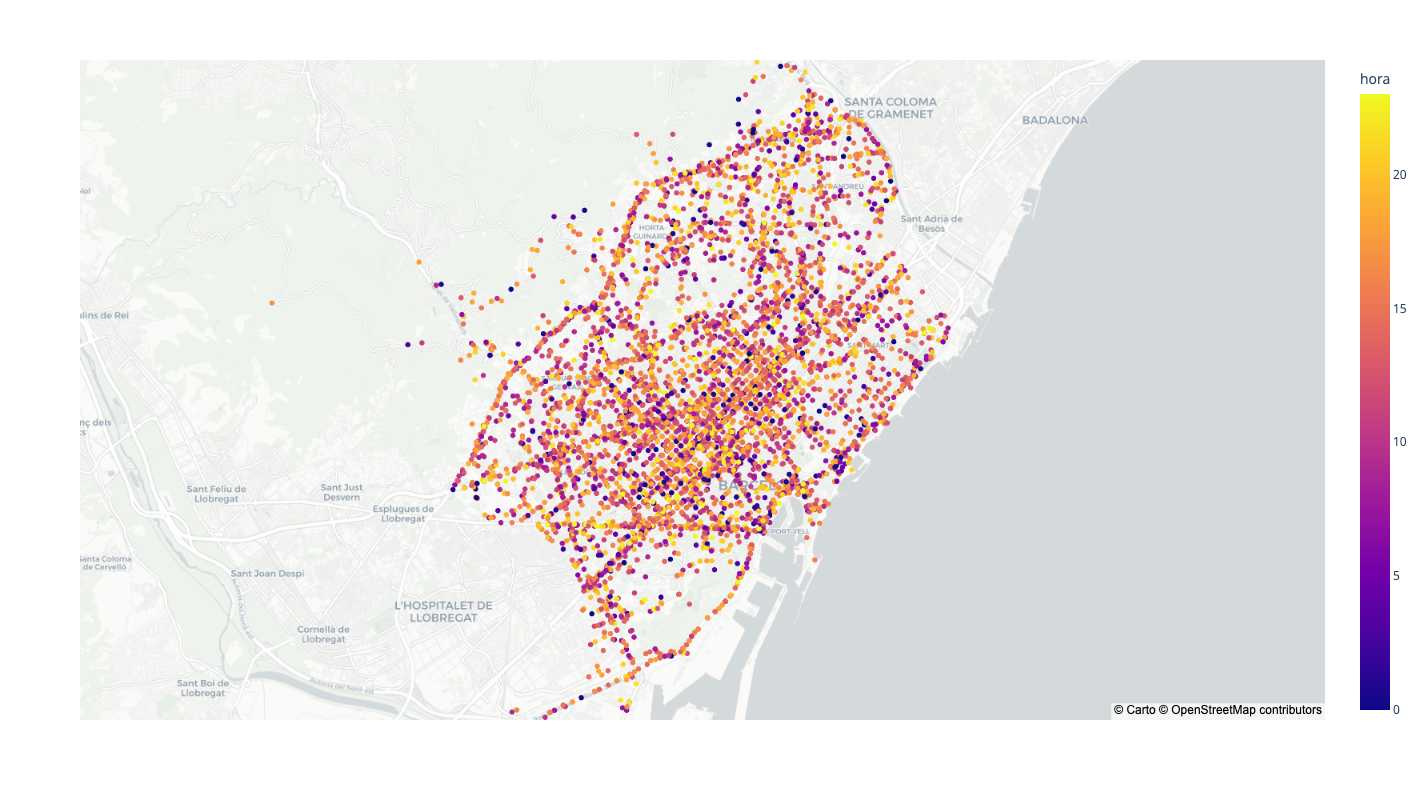

In [103]:
import plotly.express as px

# Create a Plotly scatter mapbox plot
fig = px.scatter_mapbox(
    df_clean,
    lat="lat",
    lon="long",
    hover_name="morts",
    color="hora",
    mapbox_style="carto-positron",
    zoom=11.5,
    height=800
)

fig.show()

##### pip install datashader holoviews bokeh

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
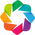

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [86]:
import holoviews as hv
import datashader as ds
import datashader.transfer_functions as tf
from holoviews.operation.datashader import datashade
from bokeh.plotting import show

# Enable Holoviews Bokeh extension
hv.extension('bokeh')

# Convert the DataFrame to Holoviews Points
points = hv.Points(df_clean, ['long', 'lat'])

# Use Datashader to render the points
shaded = datashade(points, cmap=['blue'], width=800, height=400)

# Display the map
show(hv.render(shaded))

ModuleNotFoundError: No module named 'datashader.bokeh_ext'